In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import sys
sys.path.append('../joint_crab')
from utils import load_yaml
from models import Log10Parabola
import config
from gammapy.spectrum.models import LogParabola

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
tool = 'sherpa'
instrument = 'hess'
result_path = f'../results/fit'
result_file = f'{result_path}/{tool}/{instrument}/fit_results_logparabola.yaml'
contours_path = f'../results/fit/sherpa/{instrument}/fit_contours_logparabola.npy'

In [3]:
results = load_yaml(result_file)
contours = np.load(contours_path).tolist()

parameters = results['parameters']

amplitude = parameters[0]['value'] * u.Unit(parameters[0]['unit'])
reference = parameters[1]['value'] * u.Unit(parameters[1]['unit'])
alpha = parameters[2]['value'] * u.Unit(parameters[2]['unit'])
beta = parameters[3]['value'] * u.Unit(parameters[3]['unit'])

covariance = np.asarray(results['covariance'])

In [4]:
pars = np.asarray([amplitude.value, reference.value, alpha.value, beta.value])
sampled_amplitude, sampled_reference, sampled_alpha, sampled_beta = np.random.multivariate_normal(pars, covariance, 200).T

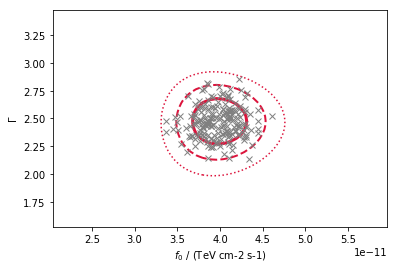

In [5]:
# check if they are correctly sampled within the contours
# let's overplot the sherpa contours to the sampled data
fig, ax = plt.subplots()

ax.plot(sampled_amplitude, sampled_alpha, marker='x', ls='', mfc='none', color='gray')

# plot sherpa contours
ampl_range = contours['contour_ampl_c1']['x0_range']
c1_range = contours['contour_ampl_c1']['x1_range']
c2_range = contours['contour_ampl_c2']['x1_range']
# actual values output of the fit
# remember in sherpa notation: (amplitude->ampl, alpha->c1, beta->c2)
ampl = results['parameters'][0]['value']
c1 = results['parameters'][2]['value']
c2 = results['parameters'][3]['value']

# axarr[0,0]
extent = [
    ampl_range[0] * 1e9,
    ampl_range[1] * 1e9,
    c1_range[0],
    c1_range[1]
]

ax.contour(
            contours['contour_ampl_c1']['like_values'],
            contours['contour_ampl_c1']['levels'],
            origin='lower',
            colors='crimson',
            extent=extent,
            linewidths=(3., 2., 1.5),
            linestyles=('-', '--', ':')
        )

ax.set_xlabel(r'$f_0$ / (TeV cm-2 s-1)')
ax.set_ylabel(r'$\Gamma$')
plt.show()

In [6]:
# now evaluate the model on a series of energy points
energy_range = config.energy_ranges[instrument]
energies = np.logspace(np.log10(energy_range[0].value), np.log10(energy_range[1].value), 200) * energy_range[0].unit 

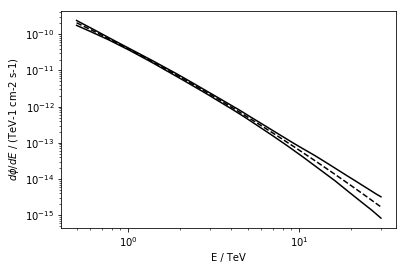

In [7]:
# determine the quantiles
flux_min = []
flux_max = []

for ene in energies:
    # flux at this energies
    _flux = []
    for amp, ref, a, b in zip(sampled_amplitude, sampled_reference, sampled_alpha, sampled_beta):
        # give them the units of the sampled quantities
        amp *= u.Unit(parameters[0]['unit'])
        ref *= u.Unit(parameters[1]['unit'])
        a *= u.Unit(parameters[2]['unit'])
        b *= u.Unit(parameters[3]['unit'])
        
        _flux.append(Log10Parabola.evaluate(ene, amp, ref, a, b).value)
        
        
    _flux_min = np.percentile(np.asarray(_flux), 16)
    _flux_max = np.percentile(np.asarray(_flux), 86)
    #print(f'{_flux_min} < flux < {_flux_max}')
    
    flux_min.append(_flux_min)
    flux_max.append(_flux_max)

flux_min = np.asarray(flux_min)
flux_max = np.asarray(flux_max)

plt.plot(energies, Log10Parabola.evaluate(energies, amplitude, reference, alpha, beta), color='k',ls='--')
plt.plot(energies, flux_min, color='k')
plt.plot(energies, flux_max, color='k')
plt.ylabel(r'$d\phi/dE$ / (TeV-1 cm-2 s-1)')
plt.xlabel(r'E / TeV')
plt.xscale('log')
plt.yscale('log')

In [8]:
def butterfly(model, energy_range):
    """returns energy and low and high points for the butterfly"""
    # generate fifty points in energy
    energy = np.logspace(
        np.log10(energy_range[0].value),
        np.log10(energy_range[-1].value),
        50
    ) * u.Unit(energy_range[0].unit)

    # differential flux
    dnde = model(energy)
    # error on dofferential flux
    dnde_err = model.evaluate_error(energy)
    # evaluate_err retrns a tuple whose second value is the error
    dnde_err = dnde_err[1]

    fhi = dnde * (1.0 + dnde_err / dnde)
    flo = dnde / (1.0 + dnde_err / dnde)

    sed_lo_log = energy ** 2 * flo
    sed_hi_log = energy ** 2 * fhi
    
    sed_lo_lin = energy ** 2 * (dnde - dnde_err)
    sed_hi_lin = energy ** 2 * (dnde + dnde_err)
    
    return energy, sed_lo_log, sed_hi_log, sed_lo_lin, sed_hi_lin


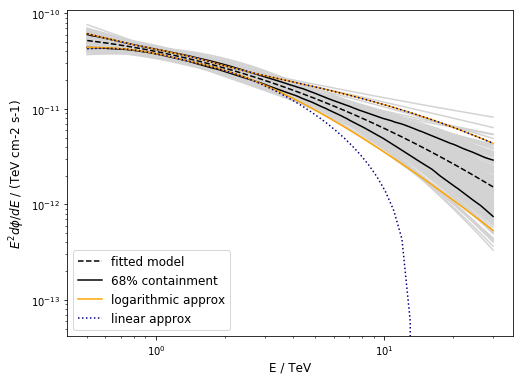

In [9]:
fig = plt.figure(figsize=(8,6))
# calculate the model per each sampled triplet
for amp, ref, a, b in zip(sampled_amplitude, sampled_reference, sampled_alpha, sampled_beta):
    # give them the units of the sampled quantities
    amp *= u.Unit(parameters[0]['unit'])
    ref *= u.Unit(parameters[1]['unit'])
    a *= u.Unit(parameters[2]['unit'])
    b *= u.Unit(parameters[3]['unit'])
        
    # plot the sampled models
    plt.plot(energies, energies**2*Log10Parabola.evaluate(energies, amp, ref, a, b), color='lightgray')

plt.plot(energies, energies**2*Log10Parabola.evaluate(energies, amplitude, reference, alpha, beta), color='k', lw=1.5, 
         ls='--', label='fitted model')
plt.plot(energies, energies**2*flux_min, color='k', lw=1.5)
plt.plot(energies, energies**2*flux_max, color='k', lw=1.5, label='68% containment')

# plot the other 2 methods
model_lp = LogParabola.from_log10(
    amplitude=parameters[0]['value'] * u.Unit(parameters[0]['unit']),
    reference=parameters[1]['value'] * u.Unit(parameters[1]['unit']),
    alpha=parameters[2]['value'] * u.Unit(parameters[2]['unit']),
    beta=parameters[3]['value'] * u.Unit(parameters[3]['unit'])
)
# set the covariance matrix from the output of the fit
model_lp.parameters.set_parameter_covariance(
    np.asarray(results['covariance']),
    ['amplitude', 'reference', 'alpha', 'beta']
)

energy, sed_lo_log, sed_hi_log, sed_lo_lin, sed_hi_lin = butterfly(model_lp, energy_range)
plt.plot(energy, sed_lo_log, color='orange', lw=1.5, label='logarithmic approx')
plt.plot(energy, sed_hi_log, color='orange', lw=1.5)

plt.plot(energy, sed_lo_lin, color='navy', lw=1.5, ls=':', label='linear approx')
plt.plot(energy, sed_hi_lin, color='navy', lw=1.5, ls=':')

plt.ylabel(r'$E^2 d\phi/dE$ / (TeV cm-2 s-1)', size=12)
plt.xlabel(r'E / TeV', size=12)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)